In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import KFold
# ML Models
import lightgbm as lgb
from lightgbm import LGBMRegressor 
import xgboost as xg 
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import tree#决策树回归

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.utils import shuffle
import numpy as np
import pandas as pd          
import matplotlib.pyplot as plt
from datetime import datetime    
from pandas import Series 
from math import sqrt
# from statsmodels.tsa.seasonal import seasonal_decompose
# import statsmodels
# import statsmodels.api as sm
# from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
import matplotlib as mpl
import os
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei',font_scale=1.2)  # 解决Seaborn中文显示问题并调整字体大小

from math import sqrt

# Model Tuning 
from bayes_opt import BayesianOptimization

In [16]:
## 加载数据，已在excel里按日期从早到晚排序
df  = pd.read_csv("./全部数据/day_sum.csv")
# pre = pd.read_csv("./全部数据/predict_sku1.csv")

# df.sort_values('order_date',ascending=True)
# # 把日期变为索引
# df['order_date'] = pd.to_datetime(df['order_date'], infer_datetime_format=True)
# # # print info to check conversion 
# df=df.set_index(['order_date']) # set date as index or rest_index() 

# # df['channel'] = 0
# # df.channel[(df.sales_chan_name == 'offline')] = 1
# # df.channel[(df.sales_chan_name == 'online')] = 2

# df = df.drop(columns = ['sales_chan_name','item_price'])  # 先删除price列，因为predict_sku0没有price特征，后面可看看利用price

first_col = df.pop('ord_qty')
df.insert(0, 'ord_qty', first_col)  #把订单量变为第一列

display(df)  # 1187days
df.info()
# display(df.iloc[1])


,ord_qty,order_date,item_code,sales_region_code,first_cate_code,second_cate_code,year,month,day,item_price,brand_qty_median,lag_30,rmean_30_30
0,12,2015/9/1,20028,104,301,405,2015,9,1,1012.000000,28,0,0.000000
1,19,2015/9/1,22069,104,307,403,2015,9,1,1114.000000,41,0,0.000000
2,18,2015/9/2,20657,101,303,410,2015,9,2,2996.000000,22,0,0.000000
3,502,2015/9/2,20323,102,305,412,2015,9,2,99.000000,28,4,246.433333
4,308,2015/9/2,20457,102,305,412,2015,9,2,164.000000,28,155,230.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
376471,10,2018/12/20,22006,105,302,408,2018,12,20,755.500000,24,0,0.000000
376472,7,2018/12/20,22028,105,305,412,2018,12,20,246.000000,28,4,18.233333
376473,56,2018/12/20,22058,105,302,408,2018,12,20,1354.666667,24,5,76.100000
376474,248,2018/12/20,22072,105,305,412,2018,12,20,427.000000,28,35,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376476 entries, 0 to 376475
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ord_qty            376476 non-null  int64  
 1   order_date         376476 non-null  object 
 2   item_code          376476 non-null  int64  
 3   sales_region_code  376476 non-null  int64  
 4   first_cate_code    376476 non-null  int64  
 5   second_cate_code   376476 non-null  int64  
 6   year               376476 non-null  int64  
 7   month              376476 non-null  int64  
 8   day                376476 non-null  int64  
 9   item_price         376476 non-null  float64
 10  brand_qty_median   376476 non-null  int64  
 11  lag_30             376476 non-null  int64  
 12  rmean_30_30        376476 non-null  float64
dtypes: float64(2), int64(10), object(1)
memory usage: 37.3+ MB


In [17]:
# testset_start = df[(df.year==2018)&(df.week==39)].index.tolist()[0]
# month1_end = df[(df.year==2018)&(df.week==42)].index.tolist()[-1]
# month2_end = df[(df.year==2018)&(df.week==46)].index.tolist()[-1]
# testset_end = df[(df.year==2018)&(df.week==50)].index.tolist()[-1]
# print(testset_start, month1_end, month2_end, testset_end)
testset_start = df[(df.year==2018)&(df.month==9)].index.tolist()[0]
month1_end = df[(df.year==2018)&(df.month==9)].index.tolist()[-1]
month2_end = df[(df.year==2018)&(df.month==10)].index.tolist()[-1]
testset_end = df[(df.year==2018)&(df.month==11)].index.tolist()[-1]
print(testset_start, month1_end, month2_end, testset_end)

323196 337292 352340 367263


In [18]:
# month1: 9下旬-10下旬 39-42周， month2: 10下旬-11下旬 43-46周， moth3：11下旬-12下旬 47-50周
len_month1 = month1_end-testset_start+1
len_month2 = month2_end-month1_end
len_month3 = testset_end-month2_end
print(len_month1,len_month2,len_month3)

14097 15048 14923


In [19]:
df_test = df.iloc[testset_start:testset_end]
# display(df_test)
df_train = df.iloc[0:testset_start-1]
# display(df_train)

In [20]:
# 拆分训练/验证集, 验证集为2018.9 - 2018.11数据， 训练集为验证集之前的数据
X_train = df.iloc[0:testset_start-1,2:].values
Y_train = df.iloc[0:testset_start-1,0].values
X_test = df.iloc[testset_start:testset_end,2:].values
Y_test = df.iloc[testset_start:testset_end,0].values
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=False, random_state=33)  # 暂不打乱数据集

In [21]:
# display(X_train)
print(X_train.shape)
# display(Y_train)
print(Y_train.shape)
# display(X_test)
print(X_test.shape)
# display(Y_test)
print(Y_test.shape)

(323195, 11)
(323195,)
(44067, 11)
(44067,)


In [22]:
# print(Y_test)
# print(type(Y_test))
# a = Y_test[0:3].sum()
# b = Y_test[1:2].sum()
# c = Y_test[5:8].sum()
# d = [a, b,c]
# print(d)

此处可不运行

In [69]:
## 封装一个模型对比函数
def try_different_method(model, method):
    model.fit(X_train, Y_train)
#     score = model.oob_score_
    Y_pre = model.predict(X_test)
    Y_train_pre = model.predict(X_train)
    plt.figure(figsize=(15,8))
#     Y_test_inv = ss_y.inverse_transform(Y_test.reshape(-1, 1))
#     Y_pre_inv = ss_y.inverse_transform(Y_pre.reshape(-1, 1))
#     plt.plot(np.arange(len(Y_pre)), ss_y.inverse_transform(Y_test.reshape(-1, 1)), "b-", label="真实值")
#     plt.plot(np.arange(len(Y_pre)), ss_y.inverse_transform(Y_pre.reshape(-1, 1)), "r-", label="预测值")
    plt.plot(np.arange(len(Y_pre)), Y_test, "b-", label="真实值")
    plt.plot(np.arange(len(Y_pre)), Y_pre, "r--", label="预测值")
    plt.title(f"method:{method}")
    plt.xlabel('测试样本个数')
    plt.ylabel('订单需求量')
    plt.legend(loc="best")
    plt.show()
    
#   打印评价指标
#     print(f'验证集袋外评分:{score}')
    # 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
    print('----------验证集-周----------')
    print("mae:", mean_absolute_error(Y_test, Y_pre))
    print("mape:", mean_absolute_percentage_error(Y_test, Y_pre))
    print("mse:", mean_squared_error(Y_test, Y_pre))
    print("rmse:", sqrt(mean_squared_error(Y_test, Y_pre)))
    print("r2 score:", r2_score(Y_test, Y_pre))
    print('----------训练集-周----------')
    print("mae:", mean_absolute_error(Y_train, Y_train_pre))
    print("mape:", mean_absolute_percentage_error(Y_train, Y_train_pre))
    print("mse:", mean_squared_error(Y_train, Y_train_pre))
    print("rmse:", sqrt(mean_squared_error(Y_train, Y_train_pre)))
    print("r2 score:", r2_score(Y_train, Y_train_pre))
    
    df_test_copy = df_test
    df_test_copy.insert(loc=0, column='ord_qty_pre', value=Y_pre) 
#     display(df_test_copy)
    df_test_copy = df_test_copy.groupby(['year','month','sales_region_code', 'item_code', 'first_cate_code','second_cate_code'], as_index=False).agg({'ord_qty': 'sum','ord_qty_pre':'sum'})
#     display(df_test_copy)
    
    df_train_copy = df_train
    df_train_copy.insert(loc=0, column='ord_qty_pre', value=Y_train_pre) 
#     display(df_train_copy)
    df_train_copy = df_train_copy.groupby(['year','month','sales_region_code', 'item_code', 'first_cate_code','second_cate_code'], as_index=False).agg({'ord_qty': 'sum','ord_qty_pre':'sum'})
#     display(df_train_copy)

     # 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
    print('----------验证集-月----------')
    print("mae:", mean_absolute_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
    print("mape:", mean_absolute_percentage_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
    print("mse:", mean_squared_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
    print("rmse:", sqrt(mean_squared_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre'])))
    print("r2 score:", r2_score(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
    print('----------训练集-月----------')
    print("mae:", mean_absolute_error(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre']))
    print("mape:", mean_absolute_percentage_error(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre']))
    print("mse:", mean_squared_error(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre']))
    print("rmse:", sqrt(mean_squared_error(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre'])))
    print("r2 score:", r2_score(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre']))
    
    df_test_copy = df_test
    df_train_copy = df_train
    

In [58]:
# LGBMReg = lgb.LGBMRegressor(random_state=0).fit(X_train,Y_train)

'''使用LightGBM模型1'''
lgbm1 = lgb.LGBMRegressor(random_state=0)
# rff1 = RandomForestRegressor(n_estimators = n_estimators1, min_samples_split =min_samples_split1, oob_score = True, bootstrap = True, n_jobs = -1,random_state = 44, verbose=1)


In [70]:
try_different_method(lgbm1,'LightGBM回归1')

In [138]:
# print("LightGBM Regressor") 
# predicted_train_y = LGBMReg.predict(X_train)
# evaluateRegressor(Y_train,predicted_train_y,"    Training Set")
# predicted_valid_y = LGBMReg.predict(X_test)
# evaluateRegressor(Y_test,predicted_valid_y,"    Test Set")

Bayesian Optimization 贝叶斯优化调参 此处可开始运行

In [23]:
# ##% parameter tuning for lightgbm 
# # store the catagorical features names as a list      
# cat_features = X_train_clean_encoded.select_dtypes(['object']).columns.to_list()

# # Create the LightGBM data containers
# # Make sure that cat_features are used
# train_data=lgb.Dataset(train_X,label=train_y, categorical_feature = cat_features,free_raw_data=False)
# valid_data=lgb.Dataset(valid_X,label=valid_y, categorical_feature = cat_features,free_raw_data=False)

train_data = lgb.Dataset(data=X_train,label=Y_train)
valid_data = lgb.Dataset(data=X_test,label=Y_test)

In [24]:
# https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9
# from lightgbm import LGBMRegressor 
# from bayes_opt import BayesianOptimization
def search_best_param(X,y):
    
#     trainXY = lgb.Dataset(data=X, label=y,categorical_feature = cat_features,free_raw_data=False)
    trainXY = lgb.Dataset(data=X, label=y, free_raw_data=False)
    
    # define the lightGBM cross validation
    def lightGBM_CV(max_depth, num_leaves, n_estimators, learning_rate, subsample, colsample_bytree, 
                lambda_l1, lambda_l2, min_child_weight):
    
        params = {'boosting_type': 'gbdt', 'objective': 'regression', 'metric':'rmse', 'verbose': 1,
                  'early_stopping_round':50}  # old: verbose=-1
        
        params['max_depth'] = int(round(max_depth))
        params["num_leaves"] = int(round(num_leaves))
        params["n_estimators"] = int(round(n_estimators))
        params['learning_rate'] = learning_rate
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample_bytree
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_child_weight'] = min_child_weight
    
        score = lgb.cv(params, trainXY, nfold=3, seed=1, stratified=False, verbose_eval =False, metrics=['rmse'])

        return -np.min(score['rmse-mean']) # return negative mse to minimize mse 

    # use bayesian optimization to search for the best hyper-parameter combination
    lightGBM_Bo = BayesianOptimization(lightGBM_CV, 
                                       {
                                          'max_depth': (5, 100),
                                          'num_leaves': (20, 200),
                                          'n_estimators': (50, 1000),
                                          'learning_rate': (0.005, 0.5),
                                          'subsample': (0.5, 0.9),
                                          'colsample_bytree' :(0.5, 0.99),
                                          'lambda_l1': (0, 5),
                                          'lambda_l2': (0, 3),
                                          'min_child_weight': (1, 50) 
                                      },
                                       random_state = 1,
                                       verbose = 0
                                      )
    np.random.seed(1)
    
    lightGBM_Bo.maximize(init_points=5, n_iter=25) 
    
    params_set = lightGBM_Bo.max['params']
    
    # get the params of the maximum target     
    max_target = -np.inf
    for i in lightGBM_Bo.res: # loop thru all the residuals 
        if i['target'] > max_target:
            params_set = i['params']
            max_target = i['target']
    
    params_set.update({'verbose': -1})
    params_set.update({'metric': 'rmse'})
    params_set.update({'boosting_type': 'gbdt'})
    params_set.update({'objective': 'regression'})
    
    params_set['max_depth'] = int(round(params_set['max_depth']))
    params_set['num_leaves'] = int(round(params_set['num_leaves']))
    params_set['n_estimators'] = int(round(params_set['n_estimators']))
    params_set['seed'] = 1 #set seed
    
    return params_set

best_params = search_best_param(X_train,Y_train)
# best_params = search_best_param(X_train,Y_train,cat_features)

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Info] Start training from score 148.482373
[LightGBM] [Info] Start training from score 149.359915
[LightGBM] 

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Info] Start training from score 148.482373
[LightGBM] [Info] Start training from score 149.359915
[LightGBM] 

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Numbe

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Numbe

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used featur

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used featur

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Info] Start training from score 148.482373
[LightGBM] [Info] Start training from score 149.359915
[LightGBM] 

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used featur

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Numbe

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used featur

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Numbe

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Info] Start training from score 148.482373
[LightGBM] [Info] Start training from score 149.359915
[LightGBM] 

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used featur

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used featur

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Info] Start training from score 148.482373
[L

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Info] Start training from score 148.482373
[L

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used featur

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used featur

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Numbe

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Info] Start training from score 148.482373
[L

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used featur

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Info] Start training from score 148.482373
[LightGBM] [Info] Start training from score 149.359915
[LightGBM] 

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Info] Start training from score 148.482373
[L

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Numbe

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used featur

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Info] Start training from score 148.482373
[LightGBM] [Info] Start training from score 149.359915
[LightGBM] 

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 215462, number of used featur

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [25]:
# Print best_params
for key, value in best_params.items():
    print(key, ' : ', value)

colsample_bytree  :  0.5191368437841124
lambda_l1  :  0.8491520978228445
lambda_l2  :  2.6344275102882393
learning_rate  :  0.053681682747359794
max_depth  :  45
min_child_weight  :  47.936586977374596
n_estimators  :  557
num_leaves  :  145
subsample  :  0.6262062524024252
verbose  :  -1
metric  :  rmse
boosting_type  :  gbdt
objective  :  regression
seed  :  1


Tuning LightGBM

In [26]:
# Train lgbm_best using the best params found from Bayesian Optimization
lgbm_best = lgb.train(best_params,
                 train_data,
                 num_boost_round = 2500,
                 valid_sets = valid_data,
                 early_stopping_rounds = 50,
                 verbose_eval = 100
                 )


E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's rmse: 266.252


LightGBM model performance

In [27]:
def metrics_tuned_method(model, method):
#     model.fit(X_train, Y_train)
#     score = model.oob_score_
    Y_pre = model.predict(X_test)
    Y_train_pre = model.predict(X_train)
    plt.figure(figsize=(15,8))
#     Y_test_inv = ss_y.inverse_transform(Y_test.reshape(-1, 1))
#     Y_pre_inv = ss_y.inverse_transform(Y_pre.reshape(-1, 1))
    plt.plot(np.arange(len(Y_pre)), Y_test, "b-", label="真实值")
    plt.plot(np.arange(len(Y_pre)), Y_pre, "r--", label="预测值")
#     plt.plot(np.arange(len(Y_pre)), Y_test, "bo-", label="真实值")
#     plt.plot(np.arange(len(Y_pre)), Y_pre, "ro-", label="预测值")
    plt.title(f"method:{method}")
    plt.xlabel('测试样本个数')
    plt.ylabel('订单需求量')
    plt.legend(loc="best")
    plt.show()
    
#   打印评价指标
#     print(f'验证集袋外评分:{score}')
    # 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
    print('----------验证集----------')
    print("mae:", mean_absolute_error(Y_test, Y_pre))
    print("mape:", mean_absolute_percentage_error(Y_test, Y_pre))
    print("mse:", mean_squared_error(Y_test, Y_pre))
    print("rmse:", sqrt(mean_squared_error(Y_test, Y_pre)))
    print("r2 score:", r2_score(Y_test, Y_pre))
    print('----------训练集----------')
    print("mae:", mean_absolute_error(Y_train, Y_train_pre))
    print("mape:", mean_absolute_percentage_error(Y_train, Y_train_pre))
    print("mse:", mean_squared_error(Y_train, Y_train_pre))
    print("rmse:", sqrt(mean_squared_error(Y_train, Y_train_pre)))
    print("r2 score:", r2_score(Y_train, Y_train_pre))
    
#     predictLGBM = lgbm_best.predict(X_tt)
#     # predictLGBM_inv = ss_y_tt.inverse_transform(predictLGBM.reshape(-1,1))

#     submissionLGBM = pd.DataFrame({'id':pre['item_code'],'order_qty':predictLGBM})
#     display(submissionLGBM)

    df_test_copy = df_test
    df_test_copy.insert(loc=0, column='ord_qty_pre', value=Y_pre) 
#     display(df_test_copy)
    df_test_copy = df_test_copy.groupby(['year','month','sales_region_code', 'item_code', 'first_cate_code','second_cate_code'], as_index=False).agg({'ord_qty': 'sum','ord_qty_pre':'sum'})
#     display(df_test_copy)
    
    df_train_copy = df_train
    df_train_copy.insert(loc=0, column='ord_qty_pre', value=Y_train_pre) 
#     display(df_train_copy)
    df_train_copy = df_train_copy.groupby(['year','month','sales_region_code', 'item_code', 'first_cate_code','second_cate_code'], as_index=False).agg({'ord_qty': 'sum','ord_qty_pre':'sum'})
#     display(df_train_copy)

     # 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
    print('----------验证集-月----------')
    print("mae:", mean_absolute_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
    print("mape:", mean_absolute_percentage_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
    print("mse:", mean_squared_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
    print("rmse:", sqrt(mean_squared_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre'])))
    print("r2 score:", r2_score(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
    print('----------训练集-月----------')
    print("mae:", mean_absolute_error(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre']))
    print("mape:", mean_absolute_percentage_error(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre']))
    print("mse:", mean_squared_error(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre']))
    print("rmse:", sqrt(mean_squared_error(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre'])))
    print("r2 score:", r2_score(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre']))
    
    #     Y_pre = model.predict(X_test)
#     Y_train_pre = model.predict(X_train)
    plt.figure(figsize=(15,8))
#     Y_test_inv = ss_y.inverse_transform(Y_test.reshape(-1, 1))
#     Y_pre_inv = ss_y.inverse_transform(Y_pre.reshape(-1, 1))
    plt.plot(df_test_copy['ord_qty'], "b-", label="真实值")
    plt.plot(df_test_copy['ord_qty_pre'], "r--", label="预测值")
#     plt.plot(np.arange(len(Y_pre)), Y_test, "bo-", label="真实值")
#     plt.plot(np.arange(len(Y_pre)), Y_pre, "ro-", label="预测值")
    plt.title(f"method:{method}")
    plt.xlabel('测试样本个数')
    plt.ylabel('订单需求量')
    plt.legend(loc="best")
    plt.show()
    
    df_test_copy = df_test
    df_train_copy = df_train

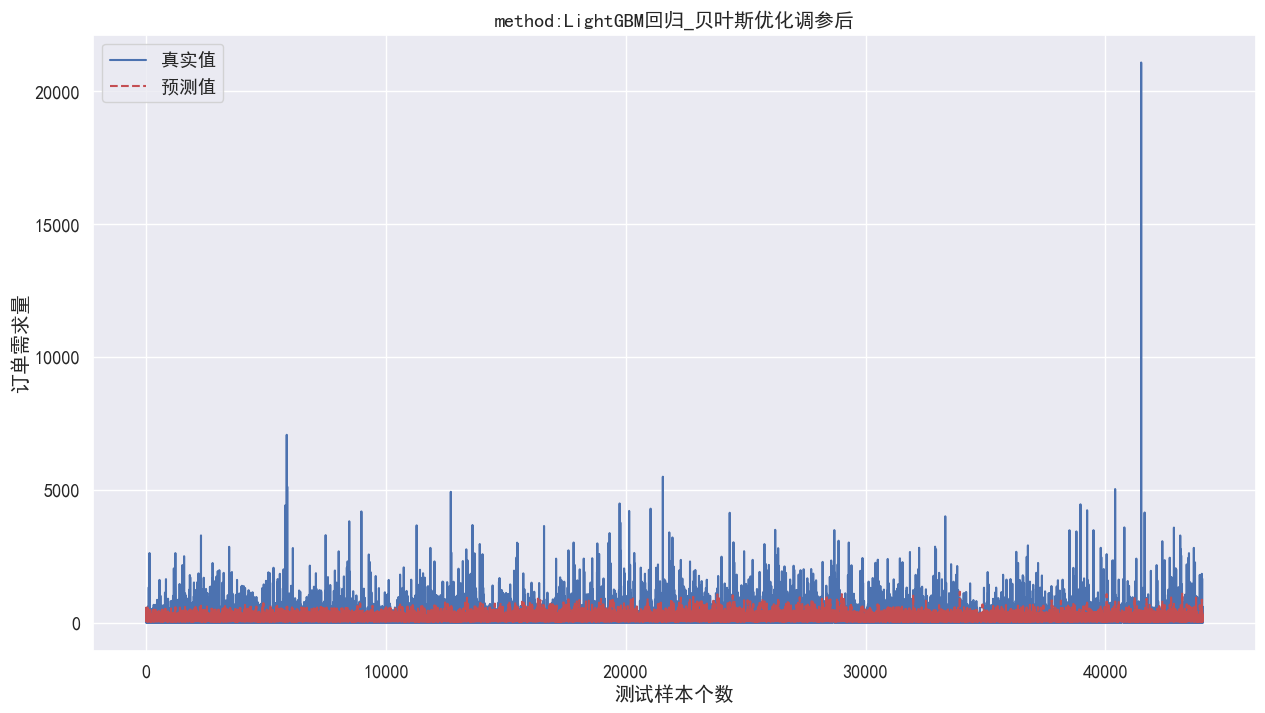

----------验证集----------
mae: 129.0138429909461
mape: 6.604590669276318
mse: 70890.35730105953
rmse: 266.25243154018244
r2 score: 0.15196956182673282
----------训练集----------
mae: 129.01510710128284
mape: 4.757439965342723
mse: 68968.35149182435
rmse: 262.61826191608293
r2 score: 0.2801537661835327
----------验证集-月----------
mae: 593.2660570710385
mape: 6.24871037823015
mse: 2283859.6772273793
rmse: 1511.244413464407
r2 score: 0.6663444344828995
----------训练集-月----------
mae: 478.599202102762
mape: 4.8931540048289985
mse: 1457638.0769842053
rmse: 1207.3268310545432
r2 score: 0.7960198916604488


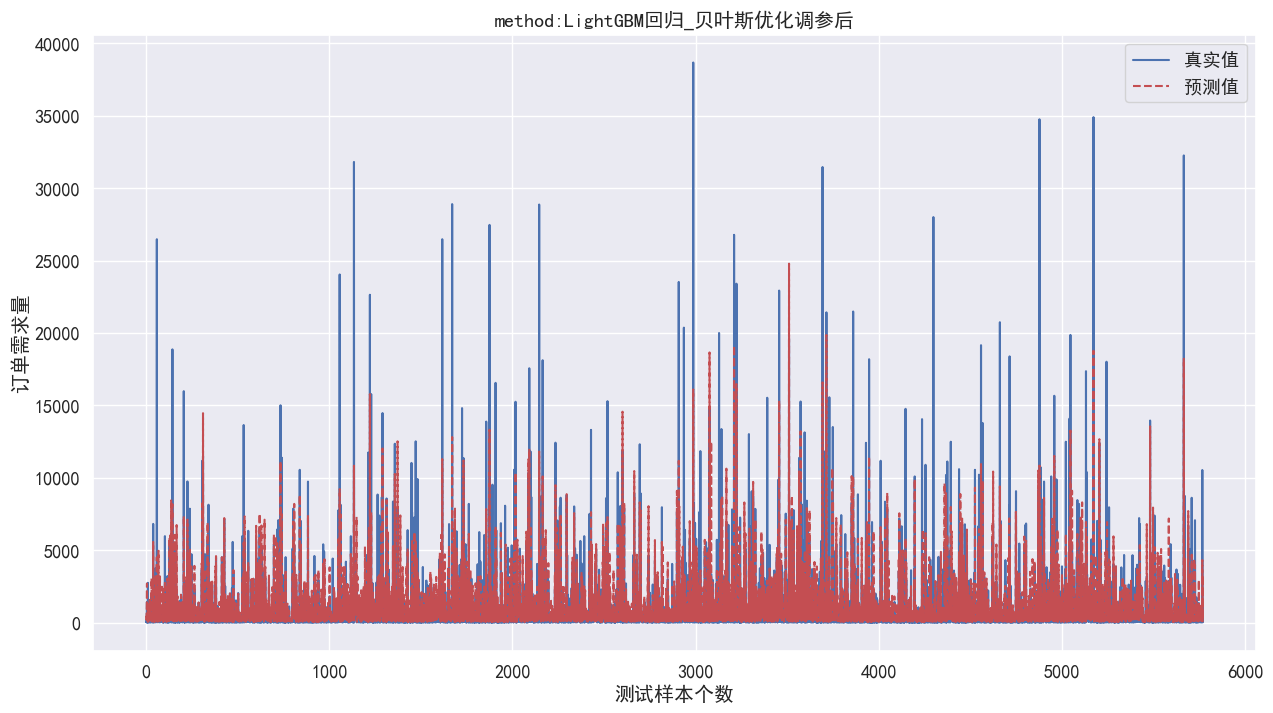

In [28]:
metrics_tuned_method(lgbm_best,'LightGBM回归_贝叶斯优化调参后')

In [54]:
Y_pre = lgbm_best.predict(X_test)
display(Y_pre)

array([ 56.06268275,  78.78738921,  62.97063841, ...,  76.90035319,
       305.17446264,  93.97416231])

In [55]:
Y_pre.shape

(44067,)

In [56]:
LGBM_pre = pd.DataFrame({'order_qty_lgbm':Y_pre})


In [57]:
display(LGBM_pre)

,order_qty_lgbm
0,56.062683
1,78.787389
2,62.970638
3,236.041439
4,53.443297
...,...
44062,55.815522
44063,36.513790
44064,76.900353
44065,305.174463


In [60]:
# # 导出LGBM在验证集的预测值
# LGBM_pre.to_csv("./全部数据/LGBM_pre.csv")

In [65]:
# df_valid=0
df_valid = df_test
# df_valid.insert(loc=0, column='ord_qty_pre', value=Y_pre) 
display(df_valid)
df_valid = df_valid.groupby(['year','month','sales_region_code', 'item_code', 'first_cate_code','second_cate_code'], as_index=False).agg({'ord_qty': 'sum','ord_qty_pre':'sum'})
display(df_valid)

,ord_qty_pre,ord_qty,order_date,item_code,sales_region_code,first_cate_code,second_cate_code,year,month,day,item_price,brand_qty_median,lag_30,rmean_30_30
323196,56.062683,4,2018/9/1,20018,101,306,407,2018,9,1,1717.0,36,10,41.200000
323197,78.787389,8,2018/9/1,20131,101,306,407,2018,9,1,964.5,36,12,48.233333
323198,62.970638,8,2018/9/1,20134,101,305,412,2018,9,1,843.0,28,2,35.566667
323199,236.041439,116,2018/9/1,20152,101,305,412,2018,9,1,207.0,28,103,248.733333
323200,53.443297,9,2018/9/1,20172,101,306,407,2018,9,1,1824.5,36,55,35.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367258,55.815522,9,2018/11/30,22045,105,302,408,2018,11,30,1665.0,24,135,43.766667
367259,36.513790,6,2018/11/30,22052,105,302,408,2018,11,30,2760.0,24,10,20.333333
367260,76.900353,62,2018/11/30,22058,105,302,408,2018,11,30,1413.0,24,198,61.333333
367261,305.174463,527,2018/11/30,22066,105,307,403,2018,11,30,324.0,41,8,430.800000


,year,month,sales_region_code,item_code,first_cate_code,second_cate_code,ord_qty,ord_qty_pre
0,2018,9,101,20002,303,406,45,162.590783
1,2018,9,101,20003,301,405,93,395.235848
2,2018,9,101,20006,307,403,109,386.105675
3,2018,9,101,20014,307,403,16,600.605621
4,2018,9,101,20016,303,401,930,1312.719541
...,...,...,...,...,...,...,...,...
5765,2018,11,105,22059,305,412,37,186.907691
5766,2018,11,105,22066,307,403,10535,4314.217063
5767,2018,11,105,22072,305,412,1842,1339.872091
5768,2018,11,105,22081,303,401,15,85.712706


In [73]:
df_v = df_valid.iloc[:,-2:]
df_v

,ord_qty,ord_qty_pre
0,45,162.590783
1,93,395.235848
2,109,386.105675
3,16,600.605621
4,930,1312.719541
...,...,...
5765,37,186.907691
5766,10535,4314.217063
5767,1842,1339.872091
5768,15,85.712706


In [74]:
df_v.to_csv("./全部数据/LGBM_pre.csv")

prediction for test data

In [46]:
# 加载待预测的数据
pre  = pd.read_csv("./全部数据/dtest_month1_day.csv")

display(pre)  # 1187days
pre.info()

,order_date,item_code,sales_region_code,first_cate_code_x,second_cate_code_x,year,month,day,item_price,brand_qty_median,lag_30,rmean_30_30
0,20190101,20002,101,303,406,2019,1,1,907.333333,36,5.000000,0.000000
1,20190101,20003,101,301,405,2019,1,1,746.000000,28,6.166667,0.000000
2,20190101,20006,101,307,403,2019,1,1,907.333333,36,7.000000,0.000000
3,20190101,20011,101,303,401,2019,1,1,907.333333,36,50.428571,54.800000
4,20190101,20014,101,307,403,2019,1,1,907.333333,36,868.000000,361.533333
...,...,...,...,...,...,...,...,...,...,...,...,...
81184,20190131,22066,105,307,403,2019,1,31,907.333333,36,406.000000,197.988889
81185,20190131,22072,105,305,412,2019,1,31,907.333333,36,50.428571,54.800000
81186,20190131,22075,105,307,403,2019,1,31,907.333333,36,50.428571,54.800000
81187,20190131,22083,105,303,401,2019,1,31,907.333333,36,185.333333,374.933333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81189 entries, 0 to 81188
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_date          81189 non-null  int64  
 1   item_code           81189 non-null  int64  
 2   sales_region_code   81189 non-null  int64  
 3   first_cate_code_x   81189 non-null  int64  
 4   second_cate_code_x  81189 non-null  int64  
 5   year                81189 non-null  int64  
 6   month               81189 non-null  int64  
 7   day                 81189 non-null  int64  
 8   item_price          81189 non-null  float64
 9   brand_qty_median    81189 non-null  int64  
 10  lag_30              81189 non-null  float64
 11  rmean_30_30         81189 non-null  float64
dtypes: float64(3), int64(9)
memory usage: 7.4 MB


In [47]:
# 拆分训练/测试集
X_tt = pre.iloc[:,1:].values

In [48]:
print(X_tt.shape)
display(X_tt)

(81189, 11)


array([[2.00020000e+04, 1.01000000e+02, 3.03000000e+02, ...,
        3.60000000e+01, 5.00000000e+00, 0.00000000e+00],
       [2.00030000e+04, 1.01000000e+02, 3.01000000e+02, ...,
        2.80000000e+01, 6.16666667e+00, 0.00000000e+00],
       [2.00060000e+04, 1.01000000e+02, 3.07000000e+02, ...,
        3.60000000e+01, 7.00000000e+00, 0.00000000e+00],
       ...,
       [2.20750000e+04, 1.05000000e+02, 3.07000000e+02, ...,
        3.60000000e+01, 5.04285714e+01, 5.48000000e+01],
       [2.20830000e+04, 1.05000000e+02, 3.03000000e+02, ...,
        3.60000000e+01, 1.85333333e+02, 3.74933333e+02],
       [2.20840000e+04, 1.05000000e+02, 3.02000000e+02, ...,
        3.60000000e+01, 9.00000000e+00, 3.75333333e+01]])

In [50]:
predictLGBM = lgbm_best.predict(X_tt)
# predictLGBM_inv = ss_y_tt.inverse_transform(predictLGBM.reshape(-1,1))
display(predictLGBM)

pre_result = pre
pre_result.insert(loc=12, column='ord_qty_pre', value=predictLGBM) 
display(pre_result)

# dtest_month1_day

# submissionLGBM = pd.DataFrame({'id':pre['item_code'],'order_qty':predictLGBM.astype(int)+1})
# display(submissionLGBM)
# display(predictLGBM)
# print(predictLGBM.astype(int))

array([160.28066602, 149.63128151, 151.8989743 , ...,  82.21142857,
       265.59891946, 152.22380907])

,order_date,item_code,sales_region_code,first_cate_code_x,second_cate_code_x,year,month,day,item_price,brand_qty_median,lag_30,rmean_30_30,ord_qty_pre
0,20190101,20002,101,303,406,2019,1,1,907.333333,36,5.000000,0.000000,160.280666
1,20190101,20003,101,301,405,2019,1,1,746.000000,28,6.166667,0.000000,149.631282
2,20190101,20006,101,307,403,2019,1,1,907.333333,36,7.000000,0.000000,151.898974
3,20190101,20011,101,303,401,2019,1,1,907.333333,36,50.428571,54.800000,91.223973
4,20190101,20014,101,307,403,2019,1,1,907.333333,36,868.000000,361.533333,261.848762
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81184,20190131,22066,105,307,403,2019,1,31,907.333333,36,406.000000,197.988889,230.494746
81185,20190131,22072,105,305,412,2019,1,31,907.333333,36,50.428571,54.800000,74.784801
81186,20190131,22075,105,307,403,2019,1,31,907.333333,36,50.428571,54.800000,82.211429
81187,20190131,22083,105,303,401,2019,1,31,907.333333,36,185.333333,374.933333,265.598919


In [51]:
pre_result.to_csv("./全部数据/dtest_month1_day_result.csv")

pre month2

In [83]:
# 加载待预测的数据
pre2  = pd.read_csv("./全部数据/dtest_month2_day.csv")

display(pre2)  # 1187days
pre2.info()

,order_date,item_code,sales_region_code,first_cate_code,second_cate_code,year,month,day,item_price,brand_qty_median,lag_30,rmean_30_30
0,2019/2/1,20002,101,303,406,2019,2,1,867.0,36,160.280666,101.362653
1,2019/2/1,20003,101,301,405,2019,2,1,857.0,28,149.631282,101.362653
2,2019/2/1,20006,101,307,403,2019,2,1,609.5,41,151.898974,101.362653
3,2019/2/1,20011,101,303,401,2019,2,1,867.0,36,91.223973,101.362653
4,2019/2/1,20014,101,307,403,2019,2,1,372.0,41,261.848762,101.362653
...,...,...,...,...,...,...,...,...,...,...,...,...
73327,2019/2/28,22066,105,307,403,2019,2,28,867.0,36,210.087615,89.157581
73328,2019/2/28,22072,105,305,412,2019,2,28,867.0,36,74.087144,81.857269
73329,2019/2/28,22075,105,307,403,2019,2,28,867.0,36,81.156336,89.157581
73330,2019/2/28,22083,105,303,401,2019,2,28,867.0,36,255.478585,150.769660


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73332 entries, 0 to 73331
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_date         73332 non-null  object 
 1   item_code          73332 non-null  int64  
 2   sales_region_code  73332 non-null  int64  
 3   first_cate_code    73332 non-null  int64  
 4   second_cate_code   73332 non-null  int64  
 5   year               73332 non-null  int64  
 6   month              73332 non-null  int64  
 7   day                73332 non-null  int64  
 8   item_price         73332 non-null  float64
 9   brand_qty_median   73332 non-null  int64  
 10  lag_30             73332 non-null  float64
 11  rmean_30_30        73332 non-null  float64
dtypes: float64(3), int64(8), object(1)
memory usage: 6.7+ MB


In [84]:
X_tt2 = pre2.iloc[:,1:].values

In [85]:
display(X_tt2)
print(X_tt2.shape)

array([[20002.        ,   101.        ,   303.        , ...,
           36.        ,   160.280666  ,   101.362653  ],
       [20003.        ,   101.        ,   301.        , ...,
           28.        ,   149.6312815 ,   101.362653  ],
       [20006.        ,   101.        ,   307.        , ...,
           41.        ,   151.8989743 ,   101.362653  ],
       ...,
       [22075.        ,   105.        ,   307.        , ...,
           36.        ,    81.15633635,    89.15758072],
       [22083.        ,   105.        ,   303.        , ...,
           36.        ,   255.4785848 ,   150.7696598 ],
       [22084.        ,   105.        ,   302.        , ...,
           36.        ,   155.098983  ,   155.9415452 ]])

(73332, 11)


In [86]:
predictLGBM2 = lgbm_best.predict(X_tt2)
# predictLGBM_inv = ss_y_tt.inverse_transform(predictLGBM.reshape(-1,1))
display(predictLGBM2)

pre_result2 = pre2
pre_result2.insert(loc=12, column='ord_qty_pre', value=predictLGBM2) 
display(pre_result2)

# dtest_month1_day

# submissionLGBM = pd.DataFrame({'id':pre['item_code'],'order_qty':predictLGBM.astype(int)+1})
# display(submissionLGBM)
# display(predictLGBM)
# print(predictLGBM.astype(int))

array([130.33927409, 133.34031622, 116.60671025, ..., 130.21977148,
       177.38389888, 159.81355479])

,order_date,item_code,sales_region_code,first_cate_code,second_cate_code,year,month,day,item_price,brand_qty_median,lag_30,rmean_30_30,ord_qty_pre
0,2019/2/1,20002,101,303,406,2019,2,1,867.0,36,160.280666,101.362653,130.339274
1,2019/2/1,20003,101,301,405,2019,2,1,857.0,28,149.631282,101.362653,133.340316
2,2019/2/1,20006,101,307,403,2019,2,1,609.5,41,151.898974,101.362653,116.606710
3,2019/2/1,20011,101,303,401,2019,2,1,867.0,36,91.223973,101.362653,116.352200
4,2019/2/1,20014,101,307,403,2019,2,1,372.0,41,261.848762,101.362653,217.640472
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73327,2019/2/28,22066,105,307,403,2019,2,28,867.0,36,210.087615,89.157581,140.831185
73328,2019/2/28,22072,105,305,412,2019,2,28,867.0,36,74.087144,81.857269,95.240552
73329,2019/2/28,22075,105,307,403,2019,2,28,867.0,36,81.156336,89.157581,130.219771
73330,2019/2/28,22083,105,303,401,2019,2,28,867.0,36,255.478585,150.769660,177.383899


In [87]:
pre_result2.to_csv("./全部数据/dtest_month2_day_result.csv")

pre month3

In [88]:
# 加载待预测的数据
pre3  = pd.read_csv("./全部数据/dtest_month3_day.csv")

display(pre3)  # 1187days
pre3.info()

,order_date,item_code,sales_region_code,first_cate_code_x_x,second_cate_code_x_x,year,month,day,item_price,brand_qty_median,lag_30,rmean_130_30
0,2019-3-1,20002,101,303,406,2019,3,1,895.00,36,130.339274,101.271593
1,2019-3-1,20003,101,301,405,2019,3,1,895.00,36,133.340316,101.271593
2,2019-3-1,20006,101,307,403,2019,3,1,895.00,36,116.606710,101.271593
3,2019-3-1,20011,101,303,401,2019,3,1,895.00,36,116.352200,101.271593
4,2019-3-1,20014,101,307,403,2019,3,1,895.00,36,217.640472,101.271593
...,...,...,...,...,...,...,...,...,...,...,...,...
81184,2019-3-31,22066,105,307,403,2019,3,31,315.97,41,NaN,90.212673
81185,2019-3-31,22072,105,305,412,2019,3,31,895.00,36,NaN,86.817776
81186,2019-3-31,22075,105,307,403,2019,3,31,895.00,36,NaN,90.212673
81187,2019-3-31,22083,105,303,401,2019,3,31,895.00,36,NaN,206.465306


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81189 entries, 0 to 81188
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_date            81189 non-null  object 
 1   item_code             81189 non-null  int64  
 2   sales_region_code     81189 non-null  int64  
 3   first_cate_code_x_x   81189 non-null  int64  
 4   second_cate_code_x_x  81189 non-null  int64  
 5   year                  81189 non-null  int64  
 6   month                 81189 non-null  int64  
 7   day                   81189 non-null  int64  
 8   item_price            81189 non-null  float64
 9   brand_qty_median      81189 non-null  int64  
 10  lag_30                73332 non-null  float64
 11  rmean_130_30          81189 non-null  float64
dtypes: float64(3), int64(8), object(1)
memory usage: 7.4+ MB


In [89]:
X_tt3 = pre3.iloc[:,1:].values

In [90]:
display(X_tt3)
print(X_tt3.shape)

array([[20002.        ,   101.        ,   303.        , ...,
           36.        ,   130.3392741 ,   101.2715933 ],
       [20003.        ,   101.        ,   301.        , ...,
           36.        ,   133.3403162 ,   101.2715933 ],
       [20006.        ,   101.        ,   307.        , ...,
           36.        ,   116.6067102 ,   101.2715933 ],
       ...,
       [22075.        ,   105.        ,   307.        , ...,
           36.        ,            nan,    90.21267294],
       [22083.        ,   105.        ,   303.        , ...,
           36.        ,            nan,   206.4653058 ],
       [22084.        ,   105.        ,   302.        , ...,
           36.        ,            nan,   164.8125091 ]])

(81189, 11)


In [91]:
predictLGBM3 = lgbm_best.predict(X_tt3)
# predictLGBM_inv = ss_y_tt.inverse_transform(predictLGBM.reshape(-1,1))
display(predictLGBM3)

pre_result3 = pre3
pre_result3.insert(loc=12, column='ord_qty_pre', value=predictLGBM3) 
display(pre_result3)

# dtest_month1_day

# submissionLGBM = pd.DataFrame({'id':pre['item_code'],'order_qty':predictLGBM.astype(int)+1})
# display(submissionLGBM)
# display(predictLGBM)
# print(predictLGBM.astype(int))

array([129.10687331, 131.70068803, 121.74694487, ...,  90.26205104,
       180.7720763 , 169.64687545])

,order_date,item_code,sales_region_code,first_cate_code_x_x,second_cate_code_x_x,year,month,day,item_price,brand_qty_median,lag_30,rmean_130_30,ord_qty_pre
0,2019-3-1,20002,101,303,406,2019,3,1,895.00,36,130.339274,101.271593,129.106873
1,2019-3-1,20003,101,301,405,2019,3,1,895.00,36,133.340316,101.271593,131.700688
2,2019-3-1,20006,101,307,403,2019,3,1,895.00,36,116.606710,101.271593,121.746945
3,2019-3-1,20011,101,303,401,2019,3,1,895.00,36,116.352200,101.271593,117.682494
4,2019-3-1,20014,101,307,403,2019,3,1,895.00,36,217.640472,101.271593,129.834755
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81184,2019-3-31,22066,105,307,403,2019,3,31,315.97,41,NaN,90.212673,230.430524
81185,2019-3-31,22072,105,305,412,2019,3,31,895.00,36,NaN,86.817776,80.743384
81186,2019-3-31,22075,105,307,403,2019,3,31,895.00,36,NaN,90.212673,90.262051
81187,2019-3-31,22083,105,303,401,2019,3,31,895.00,36,NaN,206.465306,180.772076


In [92]:
pre_result3.to_csv("./全部数据/dtest_month3_day_result.csv")